# Exp 15. OCR 모델 비교

### 1) 라이브러리 및 데이터 불러오기

In [1]:
import os
import io
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import keras_ocr
import pytesseract
from pytesseract import Output

In [2]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
file_list = os.listdir(img_dir)
file_list

['t4.png', 't5.png', 't2.png', 't3.png', 't1.png']

### 2) Keras-OCR

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

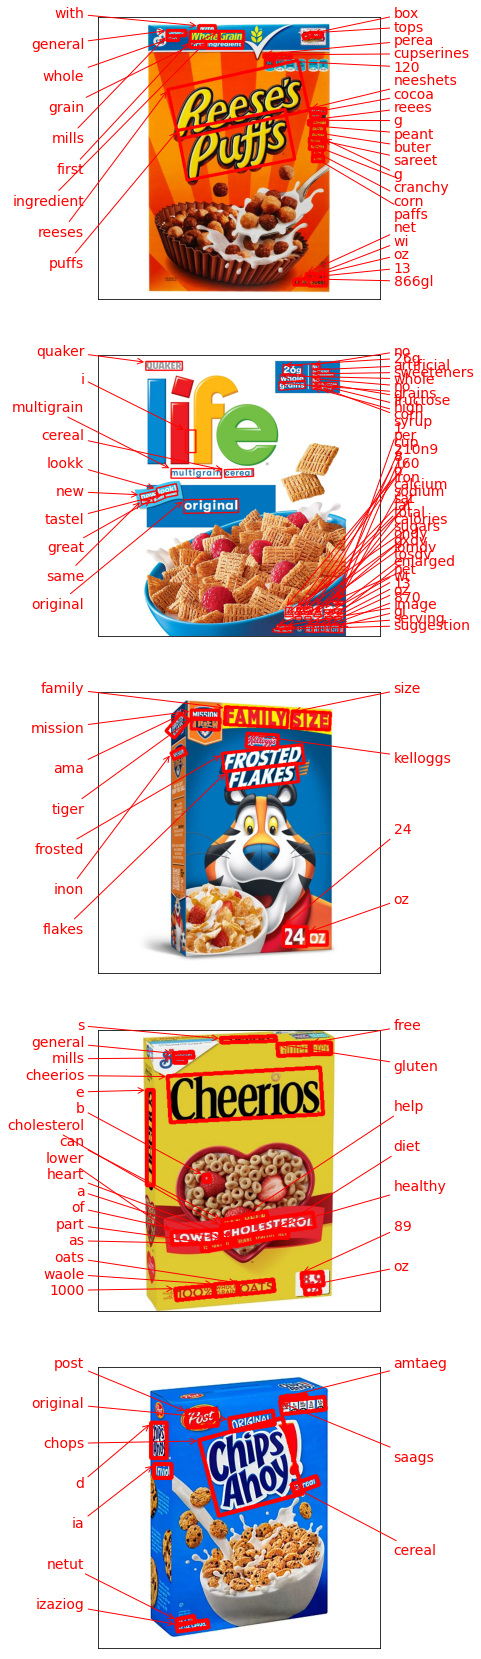

In [5]:
fig, axs = plt.subplots(nrows=len(images), figsize=(15, 30))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3) Tesseract

In [6]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
work_dir = os.getenv('HOME') + '/aiffel/ocr_python/Cropped'

for file in file_list:
    print(f"\n[[{file}]]\n")
    img_file_path = img_dir + f'/{file}'
    try:
        cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
        recognize_images(cropped_image_path_list)
    except:
        print(f'검출 불가 파일 : {file}')


[[t4.png]]

L é a

NET


13

Ls

(S000 }

Done

[[t5.png]]

NO

artiticial

Sweeteners

NO

altels

fructose

eels

iia tie

multigrain

ceread|





Original

eae

@)

anna Ryn)

“ }

Done

[[t2.png]]

검출 불가 파일 : t2.png

[[t3.png]]

a

100%

when

OATS


Done

[[t1.png]]

\

Done


### 4) 결과 분석

- keras-ocr과 tesseract를 사용해 봤음.
- 평가결과 keras-ocr이 압도적으로 성능이 좋은 것을 확인
- 즉, 가장 서비스하기 적합한 모델은 keras-ocr임